# PULSAR GAMMA-RAYS ANALYSIS: J2021+3651
#### Giovanni Cozzolongo
This script is structured with classes and modules as follows:

<ul>
<li>input_informations</li>
    <ul>
    <li>table_info</li>
    <li>columns_definitions</li>
    </ul>
<li>photons</li>
    <ul>
    <li>energy_histogram</li>
    <li>map_histogram</li>
    </ul>
<li>periodicity</li>
    <ul>
    <li>Z2n_test</li>
    <li>scanning</li>
    <li>light_curve</li>
    <li>time_phase</li>
    <li>p_pdot</li>
    </ul>
<li>phase_caraterizzation</li>
    <ul>
    <li>best_fit</li>
    <li>background</li>
    </ul>
</ul>

The aim of each class is write at the top of each of cell, wich contain the class itself. More details in the script's comments.

## Python's modules and directories
The following cell imports modules and define the directories.

In [1]:
# Import the modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from scipy import optimize
from scipy import fftpack
from scipy.optimize import curve_fit
import scipy.stats as stats
from decimal import Decimal
import time
import math

# Define the directories
work_dir = os.getcwd()
main_dir =os.path.dirname(work_dir)
data_dir = os.path.join(main_dir,"data")
results_dir = os.path.join(main_dir,"results")

## input_informations
The following cell is usefull for obtain informations and data from FITS files.

In [2]:
class input_informations():
    
    def __init__(self, input_table_filename):
        # find a file
        self.input_table_filename = os.path.join(data_dir,input_table_filename)
        
        # Now, we want to read the HDU 1. We can do by specifying the ext parameter
        data, header = fits.getdata(self.input_table_filename, ext=1,header=True)

        # We will look at the EVENTS table (HDU=1)
        self.fits_table_hdu = fits.open(self.input_table_filename)
        table_header = self.fits_table_hdu[1].header
        table_data = self.fits_table_hdu[1].data
        self.evt_data = Table(table_data)
  
    ## MODULES ##
    
    def table_info(self):
        # Access the columns definitions
        print(self.fits_table_hdu[1].columns)
        self.fits_table_hdu.info()
        
    def columns_definitions(self, column_name):
        # Access the columns data
        if(column_name == 'all'):
            print(self.evt_data)
        else:
            print(self.evt_data[column_name])

## photons
The following cell make the histogram of photons' energy (with the module **energy_histogram**) and the photons' map (with the module **map_histogram**).

In [3]:
class photons():
    
    def __init__(self, input_table_filename):
        input_informations.__init__(self, input_table_filename)
  
    ## MODULES ##
              
    def energy_histogram(self,save):
        # Plot
        plt.rcParams["font.size"] = 12
        plt.figure(figsize = (10,2))
        energy_hist = plt.hist(self.evt_data['ENERGY'], bins='auto', color = 'black', histtype='step')
        plt.xlabel("Energy [MeV]")
        plt.ylabel("Counts/bin")
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(np.amin(self.evt_data['ENERGY']),np.amax(self.evt_data['ENERGY']))
        
        # Chose to save or not
        if(save == 'y'):
            plt.savefig(os.path.join(results_dir, "energy_histogram.pdf"), bbox_inches='tight')
        plt.show()
    
    def map_histogram(self,save):
        # Plot
        plt.rcParams["font.size"] = 13
        NBINS = (50,50)
        img_zero_mpl = plt.hist2d(self.evt_data['RA'], self.evt_data['DEC'], NBINS,
                                  cmap='viridis', norm=LogNorm())
        cbar = plt.colorbar(ticks=[1.0,5.0,10.0])
        cbar.ax.set_yticklabels(['1','5','10'])
        plt.xlabel('RA [deg]')
        plt.ylabel('DEC [deg]')
        
        # Chose to save or not
        if(save == 'y'):
            plt.savefig(os.path.join(results_dir, "photons_map_300-500000.pdf"), bbox_inches='tight')
        plt.show()

## periodicity
The following cell have a modules to make each of the following things:
<ul>
<li>Z2n test;</li>
<li>scan of the first and second order term in the Taylor series of the period, respectively f_0 and f_1;</li>
<li>plot of the light_curve;</li>
<li>check if phase changes over time, to check if the values of f_0 and f_1 are wrong;</li>
<li>P-Pdot diagram with the chosen pulsar and the radio pulsars.</li>
</ul>

In [4]:
class periodicity(input_informations):
    
    def __init__(self, input_table_filename):
        input_informations.__init__(self, input_table_filename)
        self.t = self.evt_data['TIME']
        self.t_0 = (np.amax(self.t)+np.amin(self.t))/2
        
    ## MODULES ##
    
    # f_00 and f_01 are the initial value of the rotational frequency of the pulsar and its first order time derivate
    def Z2n_test(self, r_max, c_max, f_00, f_01):
        # Find the total interval of time
        T = np.amax(self.t)-np.amin(self.t)
        
        # Define the epoch
        t = self.t-self.t_0
        
        # Define the step for f_0 and f_1
        df_0 = 0.01/T     
        df_1 = 0.02/T**2
        
        # Make a matrix where each element has the value of the Z2n variable estimated for a pair of f_0 and f_1
        # (f_0 and f_1 are respectively the first and second order term in the Taylor series of the frequency)
        Z=[]
        for j in range(r_max):
            f_0 = f_00 + (j-r_max/2)*df_0
            for i in range(c_max):
                f_1 = f_01 + (i-c_max/2)*df_1
                Z2n=0
                for m in range(1,5):
                    c=0
                    s=0
                    aux = m*2*np.pi*(1+np.modf(f_0*t+0.5*f_1*t**2)[0])
                    c = np.sum(np.cos(aux))
                    s = np.sum(np.sin(aux))
                    Z2n = Z2n + c**2 + s**2
                Z.append(Z2n*2/len(t))
        self.Z2n_mat = np.reshape(Z, (r_max,c_max))
        return self.Z2n_mat
    
    def scanning(self, save, r_max, c_max, f_00, f_01):
        # Plot the a sort of intensity map for Z2n values found in the previous module "Z2n_test".
        plt.rcParams["font.size"] = 13
        plt.figure(figsize = (20,15))
        ax1 = plt.subplot(221)
        c = ax1.imshow(periodicity_class.Z2n_mat,interpolation="None",cmap="jet",aspect="auto")
        plt.colorbar(c)
        plt.ylabel("c")
        plt.xlabel("r")
        
        # chose if save the figure or not
        if(save == 'y'):
            plt.savefig(os.path.join(results_dir, "scanner.pdf"), bbox_inches='tight')
        plt.show()
        
        # Find the total time interval and the lengh of the steps used in the Z2n test
        T = np.amax(self.t)-np.amin(self.t)
        df_0 = 1/T
        df_1 = 2/T**2
        
        # Find and print the values of f_0 and f_1 corresponding to the maximum Z2n
        f_0 = f_00 + (np.where(periodicity_class.Z2n_mat==np.amax(periodicity_class.Z2n_mat))[0]-r_max/2)*df_0
        f_1 = f_01 + (np.where(periodicity_class.Z2n_mat==np.amax(periodicity_class.Z2n_mat))[1]-c_max/2)*df_1
        print("f_0 = %f $\pm$ %f." %(f_0,df_0))
        print("f_1 = %f $\pm$ %f." %(f_1,df_1))
        
    def light_curve(self, save, f_0, f_1):
        # Find the phase p given f_0 and f_1
        p = np.modf(0.15+f_0*(self.t-self.t_0)+0.5*f_1*(self.t-self.t_0)**2)[0]%1
        
        # Plot the light_curve
        plt.rcParams["font.size"] = 13
        plt.figure(figsize = (15,3))
        plt.hist(p, bins=200, color="black", histtype='step')
        plt.xlabel("Pulse Phase")
        plt.ylabel("Counts/bin")
        plt.xlim(0, 1)
        
        # Chose if save the figure or not
        if(save == 'y'):
            plt.savefig(os.path.join(results_dir, "light_curve_1000-500000.pdf"), bbox_inches='tight')
        plt.show()
    
    def time_phase(self, f_0, f_1):
        # Find the phase p given f_0 and f_1
        p = np.modf(f_0*(self.t-self.t_0)+0.5*f_1*(self.t-self.t_0)**2)[0]%1
        
        # Plot
        plt.figure(figsize = (10,10))
        plt.scatter(p,self.t,marker='.',color='black')
    
    # The quantities ending with "_mypulsar" are refered to the analysed pulsar
    def p_pdot(self, save, f_0_mypulsar, f_1_mypulsar, df_0_mypulsar, df_1_mypulsar):
        # Find the first and second order term in the Taylor series of the period, respectively p_0 and p_1.
        # Find also their uncertainties (dp_0 and d_p1), by propagation of f_0 and f_1 uncertainties (df_0 and d_f1)
        p_0_mypulsar = 1/f_0_mypulsar
        dp_0 = df_0_mypulsar/f_0_mypulsar
        p_1_mypulsar = -f_1_mypulsar/f_0_mypulsar**2
        dp_1 = np.sqrt((df_1_mypulsar/f_0_mypulsar**2)**2 + (2*f_0_mypulsar*df_0_mypulsar*f_1_mypulsar/f_0_mypulsar**4)**2)
        
        # Find the characteristic age tau and its uncertainty dtau
        tau = 0.5*p_0_mypulsar/p_1_mypulsar/(3.154e7)
        dtau = np.sqrt((0.5*dp_0/p_1_mypulsar/(3.154e7))**2+(0.5*dp_1*p_0_mypulsar/p_1_mypulsar**2/(3.154e7))**2)
        
        # Find the surface magnetic field minimal strength B_min and its uncertainty dB_min
        B_min = 3.2e19*np.sqrt(p_0_mypulsar*p_1_mypulsar)
        dB_min = np.sqrt((3.2e19*0.5*p_1_mypulsar*dp_0/np.sqrt(p_0_mypulsar*p_1_mypulsar))**2+(3.2e19*0.5*p_0_mypulsar*dp_1/np.sqrt(p_0_mypulsar*p_1_mypulsar))**2)
        
        # Value of the moment of inertia
        I = 1e45
        
        # Find the decreasing energy rate dE and its uncertainty ddE
        dE = -4*np.pi**2*I*p_1_mypulsar/p_0_mypulsar**3
        ddE = np.sqrt((-4*np.pi**2*I*dp_1/p_0_mypulsar**3)**2 + (-4*np.pi**2*I*p_1_mypulsar*3*p_0_mypulsar**2*dp_0/p_0_mypulsar**6)**2)
        
        # Print all the pulsar period and characteristic quantities values
        print("p_0 = (%f pm %f) s" %(p_0_mypulsar,dp_0))
        print("p_1 = (%f pm %f) s/s" %(p_1_mypulsar,dp_1))
        print("tau = (%f pm %f) yr" %(tau,dtau))
        print("B_min = (%f pm %f) G" %(B_min,dB_min))
        print("dE = (%f pm %f) erg/s" %(dE,ddE))
        
        # Open the radio pulsar database
        file = open(os.path.join(data_dir, 'psrcat.db'), 'r')
        read_file = file.readlines()
        
        # Find radio pulsar with f_0, f_1, p_0 and p_1 and save these values in a dataframe
        N = 0
        for li in range(20564):
            line = read_file[li].strip("\n")
            if (line[0]=="@"):
                N += 1
        period_frame = pd.DataFrame(
            {"p_0" : [0.] * N,
             "p_1" : [0.] * N})
        frequency_frame = pd.DataFrame(
            {"f_0" : [0.] * N,
             "f_1" : [0.] * N})
        i = 0
        for li in range(20564):
            line = read_file[li].strip("\n")
            if (line[0]=="@"):
                i+=1
            if (line[0]=="P"):
                if (line[1]=="0"):
                    period_frame.p_0[i] = line.partition("P0       ")[2].partition(" ")[0]
                elif (line[1]=="1"):
                    period_frame.p_1[i] = line.partition("P1       ")[2].partition(" ")[0]
            elif (line[0]=="F"):
                if (line[1]=="0"):
                    frequency_frame.f_0[i] = line.partition("F0       ")[2].partition(" ")[0]
                elif (line[1]=="1"):
                    frequency_frame.f_1[i] = line.partition("F1       ")[2].partition(" ")[0]
                        
        # Take only no-None value
        period_frame = period_frame.drop(period_frame[(period_frame['p_0'] == 0.) | (period_frame['p_1'] <= 0.)].index)
        period_frame.reset_index(drop=True, inplace=True)
        frequency_frame = frequency_frame.drop(frequency_frame[(frequency_frame['f_0'] == 0.) | (frequency_frame['f_1'] >= 0.)].index)
        frequency_frame.reset_index(drop=True, inplace=True)
        p_0_approx = 1/frequency_frame.f_0.astype(np.float)
        p_1_approx = -frequency_frame.f_1.astype(np.float)/frequency_frame.f_0.astype(np.float)**2
        p_0_approx = np.asarray(p_0_approx)
        p_1_approx = np.asarray(p_1_approx)
        p_0 = np.asarray(np.concatenate((period_frame.p_0, p_0_approx), axis=None))
        p_1 = np.asarray(np.concatenate((period_frame.p_1, p_1_approx), axis=None))
        p_0 = p_0.astype(np.float)
        p_1 = p_1.astype(np.float)
        
        # Plot the P-Pdot diagram
        plt.rcParams["font.size"] = 13
        plt.figure(figsize=(9,8))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(np.amin(p_0)/2,np.amax(p_0)*2)
        plt.ylim(np.amin(p_1)/16,np.amax(p_1)*16)
        plt.xlabel("$P$ [s]")
        plt.ylabel("$\dot{P}$ [s/s]")
        plt.scatter(p_0, p_1, color='black', marker = '.', label = 'radio pulsar')
        plt.errorbar(p_0_mypulsar, p_1_mypulsar, xerr = dp_0, yerr = dp_1, color='tab:red', marker = 'o', label = 'J2021+3651')
        
        # Draw lines for characteristic quantities
        p0_points = np.linspace(np.amin(p_0)/2, np.amax(p_0)*2, 1000)
        B_min = 1e7
        dE = -1e40
        tau = 1e2
        for i in range(0,7):
            # magnetic field
            B_min = B_min*10
            p1_points = (B_min/3.2e19)**2/p0_points
            B = plt.plot(p0_points, p1_points, color='tab:orange', linestyle = "--", alpha=0.7)
            if (i<6):
                plt.text(p0_points[0], p1_points[0], "$10^{%.0f}$ G" %(8+i), color='tab:orange', alpha=1, rotation = -23)
            
            # energy lost
            dE = dE/100
            p1_points = -dE*p0_points**3/(4*np.pi**2*I)
            if (i<6):
                E = plt.plot(p0_points, p1_points, color='tab:green', linestyle = "--", alpha=0.7)
            if (6>i>2):
                plt.text(p0_points[len(p0_points)-1], p1_points[len(p1_points)-1], "$10^{%.0f}$ erg/s" %(38-2*i), color='tab:green', alpha=1, rotation = 44)
            
            # carateristic time
            tau = tau*100
            p1_points = 0.5*p0_points/tau/(3.154e7)
            if (i<4):
                t = plt.plot(p0_points, p1_points, color='tab:blue', linestyle = "--", alpha=0.7)
            if (i<4):
                plt.text(p0_points[(len(p0_points)-1)], p1_points[(len(p1_points)-1)], "$10^{%.0f}$ yr" %(4+2*i), color='tab:blue', alpha=1, rotation = 25)
                
        # labels
        plt.plot(0, 0, color='tab:orange', linestyle = "--", alpha=0.7, label = "$B_{min}$")
        plt.plot(0, 0, color='tab:green', linestyle = "--", alpha=0.7, label = "$-dE_{rot}/dt$")
        plt.plot(0, 0, color='tab:blue', linestyle = "--", alpha=0.7, label = "$\\tau$")
            
        plt.legend(loc=('lower right'))
        
        # Chose if save or not
        if(save == 'y'):
            plt.savefig(os.path.join(results_dir, "p_pdot.pdf"), bbox_inches='tight')
        plt.show()

## phase_caraterizzation
The following cell contain a module, called **best_fit**, which makes the best fit with the last squares method, using the sum of a constant and two gauss distributions as the model function. The module for the best fit uses another module, called **background**, to find the background mean and standard deviation of the light curve.

In [5]:
class phase_caraterizzation(input_informations):
    
    def __init__(self, input_table_filename):
        input_informations.__init__(self, input_table_filename)
        self.t = self.evt_data['TIME']
        self.t_0 = (np.amax(self.t)+np.amin(self.t))/2
        
    ## MODULES ##
    
    def best_fit(self, save, p_0, p_1, start_1, end_1, start_2, end_2, pars_number, init):
        def gauss(x, costant, factor1, mean1, sigma1, factor2, mean2, sigma2):
            return costant + factor1*np.exp(-(x-mean1)**2/(2*sigma1**2)) + factor2*np.exp(-(x-mean2)**2/(2*sigma2**2))# + factor3*np.exp(-(x-mean3)**2/(2*sigma3**2)) + factor4*np.exp(-(x-mean4)**2/(2*sigma4**2)) + factor5*np.exp(-(x-mean5)**2/(2*sigma5**2)) + factor6*np.exp(-(x-mean6)**2/(2*sigma6**2))
        
        # call it to have background mean and std
        p = np.modf(0.15+p_0*(self.t-self.t_0)+0.5*p_1*(self.t-self.t_0)**2)[0]%1
        bin_number = 100
        output_hist = plt.hist(p, bins=bin_number, label="photons", color="black", histtype='step')
        plt.close()
        
        #find background and treshold levels
        data_frame = pd.DataFrame(
            {"heights" : output_hist[0],
             "phase" : output_hist[1][:bin_number]+0.5/bin_number})
        self.background(data_frame, start_1, end_1, start_2, end_2)
        
        # take only data above the threshold
        phase_filtered = data_frame.loc[data_frame['heights']>self.mean+3*self.std, 'phase']
        heights_filtered = data_frame.loc[data_frame['heights']>self.mean+3*self.std, 'heights']
        phase_filtered.reset_index(drop=True, inplace=True)
        heights_filtered.reset_index(drop=True, inplace=True)
        
        # take only no-NAN value
        phase_filtered = phase_filtered[phase_filtered.notna()]
        heights_filtered = heights_filtered[heights_filtered.notna()]
        
        # set the errors
        dx = [0]*len(data_frame['heights'])
        dy = np.sqrt(data_frame['heights'])
        sigma = dy
        
        # call the minimization routine
        popt, pcov = optimize.curve_fit(gauss, phase_filtered, heights_filtered, init, np.sqrt(heights_filtered), absolute_sigma=False)
            
        # find the chi square value
        chisq = (((heights_filtered - gauss(phase_filtered, *popt))/np.sqrt(gauss(phase_filtered, *popt)))**2).sum()
            
        # determine the ndof
        ndof=len(heights_filtered)-pars_number-1
        
        # Print the fit output
        print("Chisquare/ndof = %f/%f" %(chisq,ndof))
        print("p = %f" %(1 - stats.chi2.cdf(chisq,ndof)))
        print("cost =%f +/- %f" %(popt[0],pcov[0,0]**0.5))
        k = 0
        for j in range(int((pars_number-1)/3)):
            print("factor_%i =%f +/- %f" %(k/3+1,popt[k+1],pcov[k+1,k+1]**0.5))
            print("mean_%i =%f +/- %f" %(k/3+1,popt[k+2],pcov[k+2,k+2]**0.5))
            print("std_%i =%f +/- %f" %(k/3+1,popt[k+3],pcov[k+3,k+3]**0.5))
            k = k + 3
        print("\n")
        
        # prepare a dummy xx array (with 1000 linearly spaced points)
        x_points_1 = np.linspace(0.05, 0.15, 1000)
        x_points_2 = np.linspace(0.6, 0.671, 1000)
        x_points = np.linspace(0, 1, 1000)
        
        # Plot the light curve best fit
        plt.rcParams["font.size"] = 13
        f = plt.figure(figsize=(16,3))
        frame1=f.add_axes((.1,.4,.6,.6))
        plt.axhline(y=self.mean, label="background", color='tab:blue', linestyle='--')
        plt.axhline(y=self.mean+3*self.std, label="threshold", color='tab:green', linestyle='--')
        plt.xlabel("Pulsar phase")
        plt.ylabel("Counts/bin")
        plt.errorbar(data_frame.phase, data_frame.heights, color='black', marker = '', yerr=np.sqrt(data_frame.heights), ls='none', zorder=1, capsize=0,elinewidth=1,markeredgewidth=1)
        plt.hist(p, bins=bin_number, label="photons", color="black", histtype='step')
        fit_value_1 = plt.plot(x_points_1, gauss(x_points_1, *popt), 'tab:red', label = 'best-fit')
        fit_value_2 = plt.plot(x_points_2, gauss(x_points_2, *popt), 'tab:red')
        p = 1 - stats.chi2.cdf(chisq, ndof) 
        plt.legend(loc=('upper right'))
        
        if(save == 'y'):
            plt.savefig(os.path.join(results_dir, "best_fit_100-1000.pdf"), bbox_inches='tight')
        plt.show()
        
        fit_value_1 = fit_value_1[0].get_data()
        fit_value_2 = fit_value_2[0].get_data()
        fit_frame = pd.DataFrame(
            {"heights" : np.concatenate((fit_value_1[1],fit_value_2[1]), axis=None),
             "phase" : np.concatenate((fit_value_1[0],fit_value_2[0]), axis=None)})
        diff = fit_frame.loc[(fit_frame['heights'] == np.amax(fit_value_2[1])),'phase'].iloc[0]-fit_frame.loc[fit_frame['heights'] == np.amax(fit_value_1[1]),'phase'].iloc[0]
        d_pick = np.sqrt((1/bin_number/np.amax(fit_value_2[1]))**2+(1/bin_number*np.amax(fit_value_1[1])/np.amax(fit_value_2[1])**2)**2)
        print("The picks are in %f and %f" %(fit_value_1[0][fit_value_1[1].argmax()], fit_value_2[0][fit_value_2[1].argmax()]))
        print("The picks distance is %f pm %f" %(diff,1/bin_number))
        print("The picks ratio is %f pm %f" %(np.amax(fit_value_1[1])/np.amax(fit_value_2[1]), d_pick))
        
    # Chose two background windows with phase intervals (start_1,end_1) and (start_2,end_2).
    def background(self, data_frame, end_1, start_1, end_2, start_2):
        # Take only light curve values from the indicated windows.
        background_array = data_frame.loc[((data_frame['phase']>=end_1) & (start_1>=data_frame['phase']) | (data_frame['phase']>=end_2) & (start_2>=data_frame['phase'])), 'heights'] #take just the window heights
        
         # Find the mean and standard deviation of the background
        self.mean = background_array.mean() #compute the mean value of the background window
        self.std = background_array.std() #compute the standard dev. of the background window
        
        # Print background mean and standard deviation.
        print("Background mean: ", self.mean)
        print("Background standard deviation: ", self.std)

## Example
The following code shows example of inputs for all the modules of each classes.

In [6]:
## input_informations ##
input_class = input_informations("dragon/dragon_3deg_100-500000_MeV_select_mktime_bary.fits")
input_class.table_info()
input_class.columns_definitions('all')

ColDefs(
    name = 'ENERGY'; format = 'E'; unit = 'MeV'
    name = 'RA'; format = 'E'; unit = 'deg'
    name = 'DEC'; format = 'E'; unit = 'deg'
    name = 'L'; format = 'E'; unit = 'deg'
    name = 'B'; format = 'E'; unit = 'deg'
    name = 'THETA'; format = 'E'; unit = 'deg'
    name = 'PHI'; format = 'E'; unit = 'deg'
    name = 'ZENITH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'EARTH_AZIMUTH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'EVENT_ID'; format = 'J'
    name = 'RUN_ID'; format = 'J'
    name = 'RECON_VERSION'; format = 'I'
    name = 'CALIB_VERSION'; format = '3I'
    name = 'EVENT_CLASS'; format = '32X'
    name = 'EVENT_TYPE'; format = '32X'
    name = 'CONVERSION_TYPE'; format = 'I'
    name = 'LIVETIME'; format = 'D'; unit = 's'
    name = 'DIFRSP0'; format = 'E'
    name = 'DIFRSP1'; format = 'E'
    name = 'DIFRSP2'; format = 'E'
    name = 'DIFRSP3'; format = 'E'
    name = 'DIFRSP4'; format = 'E'
)
Filename: /home

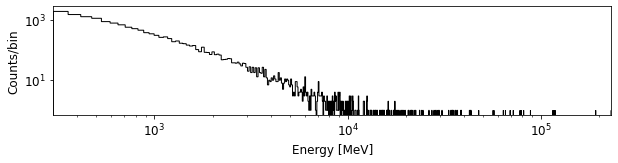

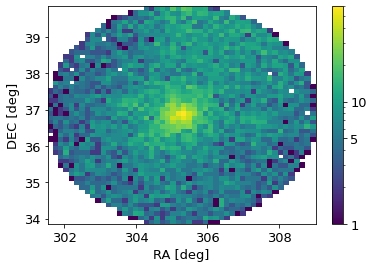

In [7]:
## photons ##
photons_class = photons("dragon/dragon_3deg_300-500000_MeV_select_mktime_bary.fits")
photons_class.energy_histogram('n')
photons_class.map_histogram('n')

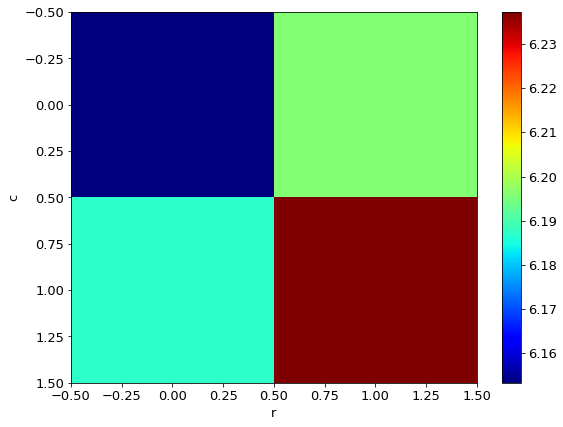

f_0 = 9.639350 $\pm$ 0.000000.
f_1 = -0.000000 $\pm$ 0.000000.


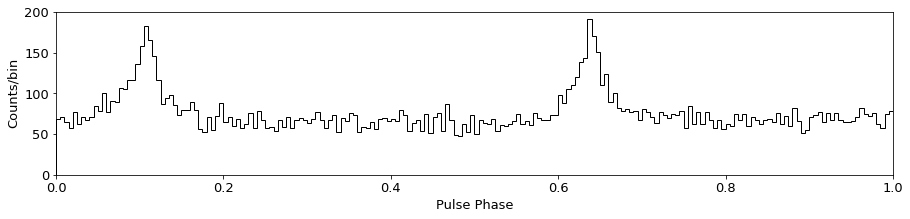

p_0 = (0.103741 pm 0.000000) s
p_1 = (0.000000 pm 0.000000) s/s
tau = (17197.723170 pm 0.640732) yr
B_min = (3187286757941.093262 pm 59374008.378522) G
dE = (-3381365673155863160069589878720954368.000000 pm 125978771295822655511676359540736.000000) erg/s


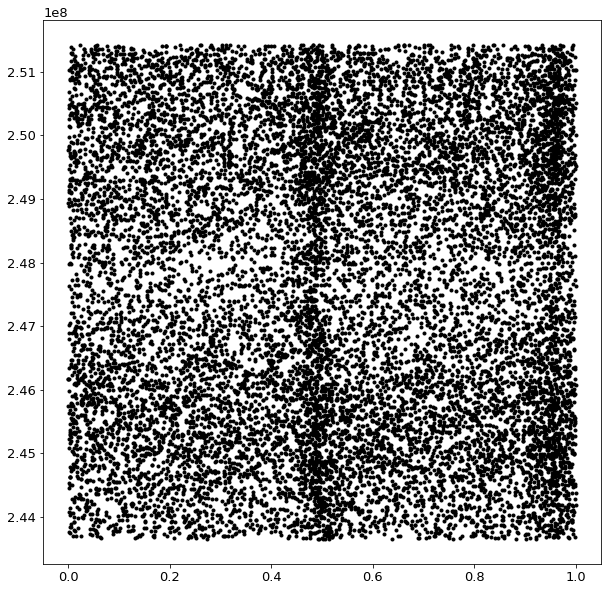

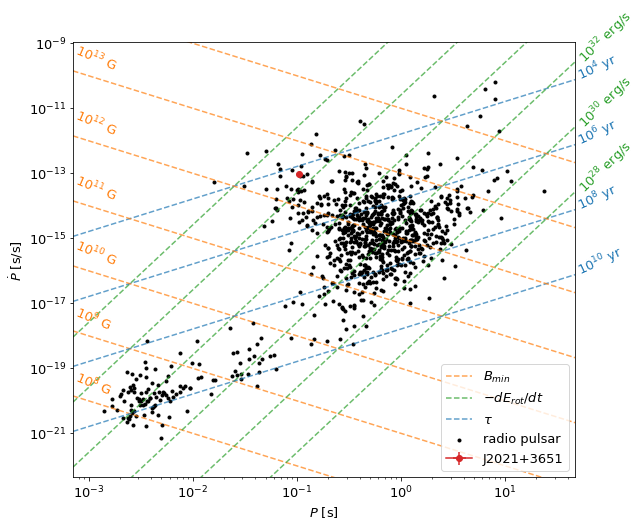

In [12]:
## periodicity ##
periodicity_class = periodicity("dragon/dragon_3deg_300-500000_MeV_select_mktime_bary.fits")

'''Note that in the module Z2n_test I have used  (r_max, c_max) = (10000, 500) for the reported results.
But I have chosed to use (r_max, c_max) = (2, 2) just to make a fast example, because with (10000, 500) it takes too much time.'''

periodicity_class.Z2n_test(2,2,9.63935,-8.8892e-12)
periodicity_class.scanning('n',2,2,9.63935,-8.8892e-12)
periodicity_class.light_curve('n',9.639344919,-8.8855616022313846e-12)
periodicity_class.time_phase(9.639344919,-8.8855616022313846e-12)
periodicity_class.p_pdot('y',9.639344919,-8.8855616022313846e-12,1.286560035e-09,3.3104734450153731e-16)

Background mean:  196.98333333333332
Background standard deviation:  16.527831347141344
Chisquare/ndof = 9.038062/7.000000
p = 0.249935
cost =258.727345 +/- 7.785585
factor_1 =140.497813 +/- 19.132496
mean_1 =0.106535 +/- 0.001456
std_1 =0.010333 +/- 0.001651
factor_2 =181.564268 +/- 19.831744
mean_2 =0.637553 +/- 0.001230
std_2 =0.011370 +/- 0.001376




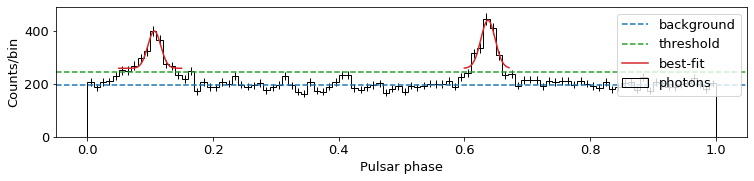

The picks are in 0.106557 and 0.637526
The picks distance is 0.530969 pm 0.010000
The picks ratio is 0.906729 pm 0.000031


In [9]:
## phase_caraterizzation ##
phase_caraterizzation_class = phase_caraterizzation("dragon/dragon_3deg_100-1000_MeV_select_mktime_bary.fits")
phase_caraterizzation_class.best_fit('n',9.639344919,-8.8855616022313846e-12,0.2,0.5,0.7,1,1+3*2,[157,1,0.11,0.006,1,0.65,0.006])
#phase_caraterizzation_class.best_fit('n',9.639344919,-8.8855616022313846e-12,0.3,0.5,0.8,1,1+3*2,[35,1,0.17,0.005,1,0.65,0.006])